the accuracy = 80.88004190675746%


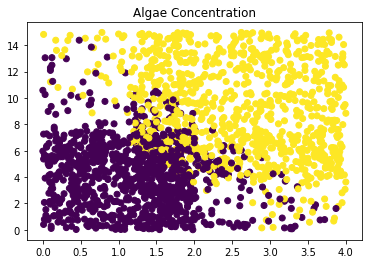

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
from matplotlib import pyplot as plt

spark = SparkSession.builder.getOrCreate()

#inferschema = spark can detect what data type
#1.
df_train = spark.read.option("inferSchema", "true").csv("Training.csv", header = True)

#2.
df_train = df_train.select("Trash Pollution", "Oil Concentration", "Algae Concentration")

#3. clear na
df_train = df_train.na.drop()

#4.
#change vector vector 0, 1, 2
df_train = df_train.withColumn("Trash Pollution",
                              when(df_train["Trash Pollution"] == "Low", 0).
                              when(df_train["Trash Pollution"] == "Medium", 1).
                              when(df_train["Trash Pollution"] == "High", 2)
                              )


#cols to return column header name
cols = df_train.columns
df_train = VectorAssembler(inputCols = cols, outputCol="Vector").transform(df_train)

#5.
#features to output col names
scaler = StandardScaler(inputCol = "Vector", outputCol="features")
df_train = scaler.fit(df_train).transform(df_train)

#6.
#2 cluster -> Cluster 1 = dirty ocean
# Cluster 2 = clean ocean  

#K -> number of cluster we want to train
#seed help random alogorithm
model = KMeans().setK(2).setSeed(1)
model = model.fit(df_train)


#Testing
#1.
df_test = spark.read.option("inferSchema", "true").csv("Testing.csv", header = True)

#2.
df_test = df_test.select("Trash Pollution", "Oil Concentration", "Algae Concentration", "Polluted")

#3. 
df_test = df_test.na.drop()

#4.
#change vector 0, 1, 2
df_test = df_test.withColumn("Trash Pollution",
                              when(df_test["Trash Pollution"] == "Low", 0).
                              when(df_test["Trash Pollution"] == "Medium", 1).
                              when(df_test["Trash Pollution"] == "High", 2)
                              )
df_test = df_test.withColumn("Polluted",
                            when(df_test["Polluted"] == "No", 0).
                            when(df_test["Polluted"] == "Yes", 1)
                            )

#result of our prediction is 0 and 1

cols = df_test.columns
cols.remove("Polluted")

df_test = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(df_test)
scaler = StandardScaler(inputCol = "Vector", outputCol="features")
df_test = scaler.fit(df_test).transform(df_test)

prediction = model.transform(df_test)

prediction = prediction.toPandas()
#panda dataframe

count = 0 #search true value
for index, row in prediction.iterrows():
    if(row["Polluted"] == row["prediction"]):
        count = count + 1
        
accuracy = (count / len(prediction)) * 100

print(f"the accuracy = {accuracy}%")

#7. vizualitation
# (datax, data y, color)
plt.scatter(prediction["Oil Concentration"], prediction["Algae Concentration"], c = prediction["prediction"])
plt.title("data clustering")
plt.title("Oil Concentration")
plt.title("Algae Concentration")
plt.show()

#prediction.show(5)
#df_test.show(5)
#df_train.show(5, False)